Data Loading and Exploration

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None
Missing values:
 review       0
sentiment    0
dtype: int64


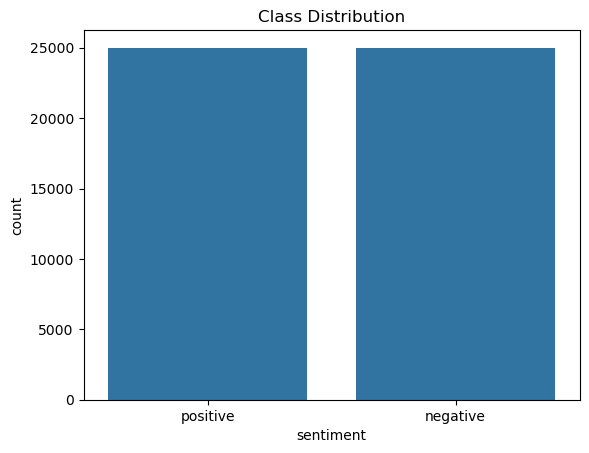

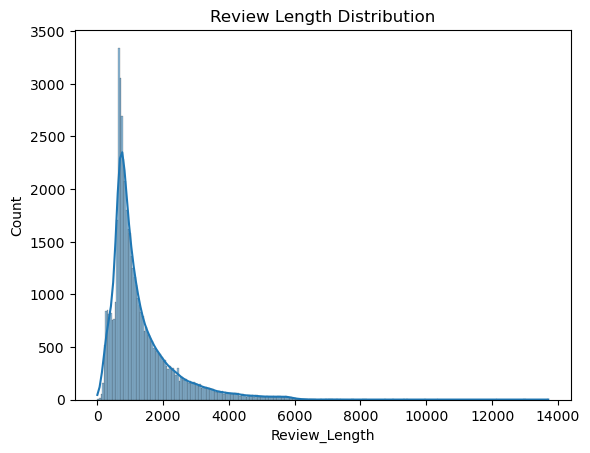

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the dataset
df = pd.read_excel('Imdb.xlsx')

# Check dataset information
print(df.info())

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Check class distribution
sns.countplot(x='sentiment', data=df)
plt.title('Class Distribution')
plt.show()

# Analyze review lengths
df['Review_Length'] = df['review'].apply(len)
sns.histplot(df['Review_Length'], kde=True)
plt.title('Review Length Distribution')
plt.show()


Data Preprocessing

In [2]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

# Text preprocessing function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing
df['Cleaned_Review'] = df['review'].apply(preprocess_text)


Feature Engineering

In [3]:
#TF-IDF Vectorization

from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit and transform the cleaned text data
tfidf_features = tfidf_vectorizer.fit_transform(df['Cleaned_Review']).toarray()

# Get feature names
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Convert to DataFrame for easier handling
tfidf_df = pd.DataFrame(tfidf_features, columns=tfidf_feature_names)

print("TF-IDF Features Shape:", tfidf_df.shape)


TF-IDF Features Shape: (50000, 5000)


In [4]:
# Textual Features

# Word Count
df['Word_Count'] = df['Cleaned_Review'].apply(lambda x: len(x.split()))

# Character Count
df['Character_Count'] = df['Cleaned_Review'].apply(len)

# Average Word Length
df['Average_Word_Length'] = df['Character_Count'] / (df['Word_Count'] + 1e-5)

# Display the first few rows of textual features
print(df[['Word_Count', 'Character_Count', 'Average_Word_Length']].head())


   Word_Count  Character_Count  Average_Word_Length
0         170             1134             6.670588
1          90              658             7.311110
2          87              582             6.689654
3          70              459             6.557142
4         130              864             6.646153


Model Development and Evaluation

Logistic Regression Accuracy: 0.8878
Confusion Matrix:
 [[4340  621]
 [ 501 4538]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.89      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Logistic Regression F1-Score: 0.8900
Logistic Regression ROC-AUC: 0.9587


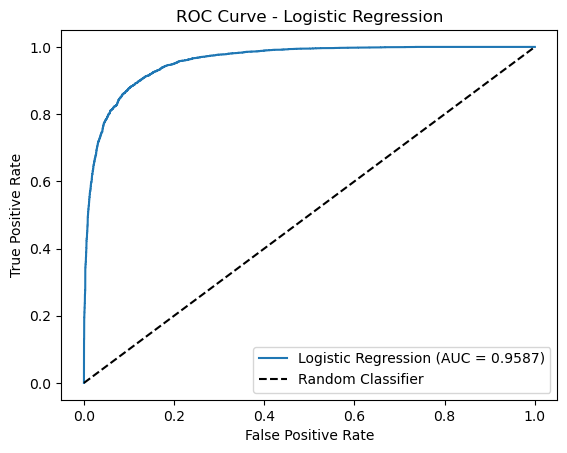

In [5]:
# LogisticRegression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

X = tfidf_features # this is nothing but which i already calculated above 'tfidf_vectorizer.fit_transform(df['Cleaned_Review']).toarray()'
y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Train model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test)

# Evaluation
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

y_prob_lr = lr_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Calculate F1-score
f1_lr = f1_score(y_test, y_pred_lr)
print(f"Logistic Regression F1-Score: {f1_lr:.4f}")

# Calculate ROC-AUC
roc_auc_lr = roc_auc_score(y_test, y_prob_lr)
print(f"Logistic Regression ROC-AUC: {roc_auc_lr:.4f}")

# Plot ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
plt.figure()
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.title("ROC Curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


Random Forest Accuracy: 0.8525
Confusion Matrix:
 [[4264  697]
 [ 778 4261]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.85      4961
           1       0.86      0.85      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Random Forest F1-Score: 0.8525
Random Forest ROC-AUC: 0.9318


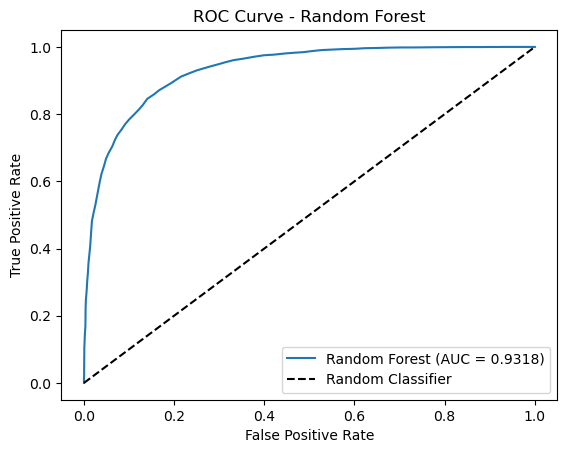

In [6]:
# RandomForest
from sklearn.ensemble import RandomForestClassifier

# Train model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

y_prob_rf = rf_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Calculate F1-score
f1_rf = f1_score(y_test, y_pred_rf)
print(f"Random Forest F1-Score: {f1_rf:.4f}")

# Calculate ROC-AUC
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
print(f"Random Forest ROC-AUC: {roc_auc_rf:.4f}")

# Plot ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
plt.figure()
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.title("ROC Curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


SVM Accuracy: 0.8526
Confusion Matrix:
 [[4166  795]
 [ 679 4360]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85      4961
           1       0.85      0.87      0.86      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

SVM F1-Score: 0.8554
SVM ROC-AUC: 0.9321


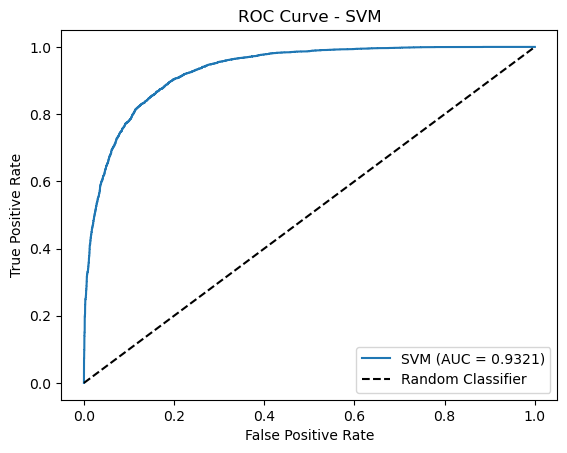

In [7]:
# Support Vector Machine
from sklearn.svm import SVC

# Train model
svm_model = SVC(kernel='linear',probability=True) ## Enable probability estimates for AUC
X_train_small = X_train[:5000]  # Use only 5000 samples for training
y_train_small = y_train[:5000]
svm_model.fit(X_train_small, y_train_small)

# Predict
y_pred_svm = svm_model.predict(X_test)

# Evaluation
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

y_prob_svm = svm_model.decision_function(X_test)  # Get scores for the positive class

# Calculate F1-score
f1_svm = f1_score(y_test, y_pred_svm)
print(f"SVM F1-Score: {f1_svm:.4f}")

# Calculate ROC-AUC
roc_auc_svm = roc_auc_score(y_test, y_prob_svm)
print(f"SVM ROC-AUC: {roc_auc_svm:.4f}")

# Plot ROC Curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
plt.figure()
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {roc_auc_svm:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.title("ROC Curve - SVM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


Visualization

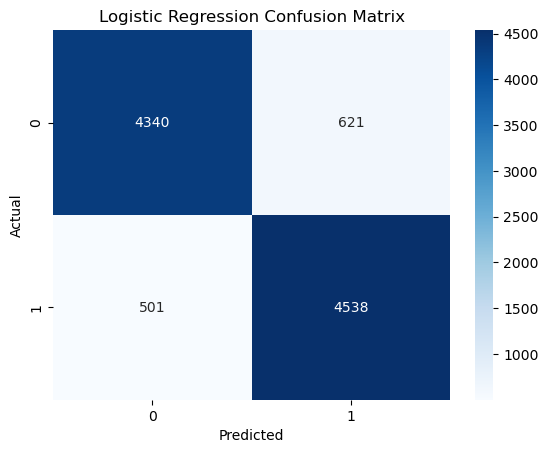

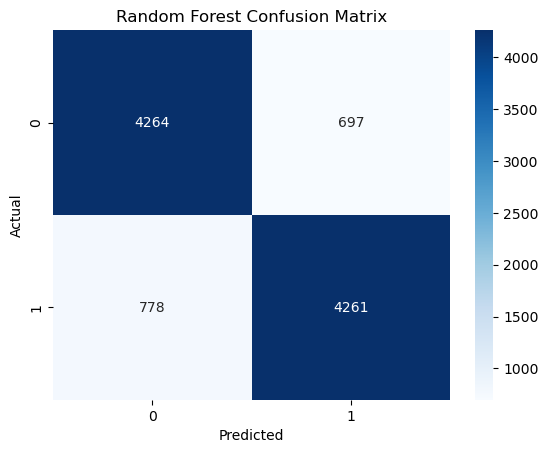

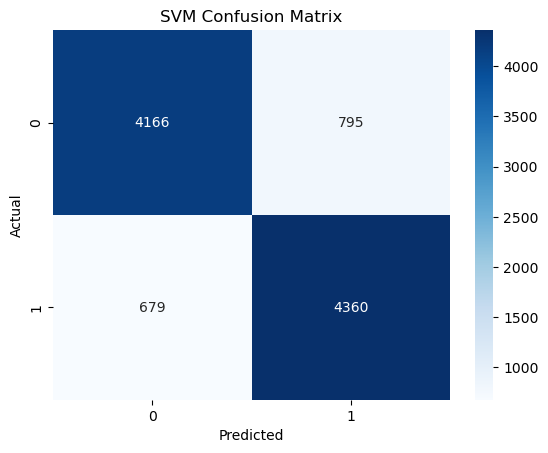

In [9]:
# Confusion Matrix Plot
def plot_confusion_matrix(cm, title):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title) 
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

cm_lr = confusion_matrix(y_test, y_pred_lr)
plot_confusion_matrix(cm_lr, "Logistic Regression Confusion Matrix")

cm_rf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cm_rf, "Random Forest Confusion Matrix")

cm_svm = confusion_matrix(y_test, y_pred_svm)
plot_confusion_matrix(cm_svm, "SVM Confusion Matrix")
